In [266]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math, copy
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [267]:
# general settings
stdsc = StandardScaler()

target = 'state'
categorical = ['main_category', 'category', 'country']
quantitative = ['usd_goal_real', 'deadline', 'launched', 'duration', 'launched_time']

In [268]:
# functions
# around datetime objects
def datetime_to_hour(x):
    return x.hour

def datetime_to_int(pdSeries):
    values = (pdSeries - pdSeries.min()).dt.total_seconds()
    return values


# visualize categorical variables
def barplots(pdSeries):
    x = pdSeries.value_counts()
    plt.figure(figsize=(20, 5))
    sns.barplot(x.index, x.values)

# visualize categorical variables
def distplots(pdSeries):
    plt.figure(figsize=(20, 3))
    sns.distplot(pdSeries)

def cross_heatmap(data, exp_val, tar_val):
    crossmat = pd.crosstab(data[exp_val], data[tar_val], normalize='index')
    sns.heatmap(crossmat, annot=True, fmt='.3f', cmap='Blues')
    

# reshape pd.DataFrame into X, y
def ready_to_fit(data, target=target, quantitatives=quantitative, categoricals=categorical):
    y = pd.get_dummies(data[target])['successful'].to_numpy()
    
    X_qnt = data[quantitatives].to_numpy()
    X_cat = pd.get_dummies(data[categoricals]).to_numpy()
    X = np.concatenate([X_qnt, X_cat], axis=1)
    
    return X, y

# check performance of models
def show_scores(y_true, y_pred):
    ac = accuracy_score(y_true, y_pred)
    pr = precision_score(y_true, y_pred)
    re = recall_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    print(f'acurracy: {ac:.3f}, precision: {pr:.3f}, recall: {re:.3f}')
    print(f'MSE: {mse:.3f}, MAE: {mae:.3f}')


In [269]:
df_origin = pd.read_csv('ks-projects-201801.csv')

In [273]:
### 1. General processing
df = copy.copy(df_origin)
df = df.set_index('ID')

# exclude: ID, name, goal, pledged, usd pledged, use_pledged_real, backers
df = df.drop(['name', 'goal', 'pledged', 'usd pledged', 'usd_pledged_real', 'backers'], axis=1)

# Use data labeled only with 'successful' or 'failed'.
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]

### 2. Process categorical variables.
# currency to country, drop currency.
df.loc[(df['country']=='N,0"') & (df['currency']!="EUR"), 'country'] = df.loc[(df['country']=='N,0"') & (df['currency']!="EUR"), 'currency'].str[:2]
df.loc[(df['country']=='N,0"') & (df['currency']=="EUR"), 'country'] = "EU"
df = df.drop('currency', axis=1)

# 'category': replace values with too small counts with values in 'main_category'
x = df['category'].value_counts()
obj_to_replace = x.index[x.values < x.describe()['75%']]
df.loc[df['category'].isin(obj_to_replace), 'category'] = df.loc[df['category'].isin(obj_to_replace), 'main_category']


### 3. Process quantitative variables.
## 3-1. Convert 'usd_goal_real' into log scale.
df['usd_goal_real'] = df['usd_goal_real'].apply(math.log10)


## 3-2. Process datetime objects.
# make 'deadline' & 'launched' computable
df.loc[:, ['deadline', 'launched']] = df.loc[:, ['deadline', 'launched']].apply(pd.to_datetime)

# Add launched time zone to explanatories.
df['launched_time'] = df['launched'].apply(datetime_to_hour)

# convert datetime objects to integers
df['deadline'] = datetime_to_int(df['deadline'])
df['launched'] = datetime_to_int(df['launched'])

# remove data that have too small launched values
# df: 378559 rows × 8 columns
df = df.loc[df['launched']!=0, :]
# df: 378552 rows × 8 columns

# generate 'duration' column
df['duration'] = df['deadline'] - df['launched']

# remove deadline, since it seems to contain almost the same information as launched values.
# df = df.drop('deadline', axis=1)

df.head()

,category,main_category,deadline,launched,state,country,usd_goal_real,launched_time,duration
ID,,,,,,,,,
1000002330,Publishing,Publishing,203040000.0,198947380.0,failed,GB,3.185811,12,4092620.0
1000003930,Narrative Film,Film & Video,268185600.0,263979669.0,failed,US,4.477121,4,4205931.0
1000004038,Narrative Film,Film & Video,120528000.0,117602282.0,failed,US,4.653213,0,2925718.0
1000007540,Music,Music,93225600.0,91606883.0,failed,US,3.698970,3,1618717.0
1000014025,Restaurants,Food,218160000.0,216146139.0,successful,US,4.698970,13,2013861.0


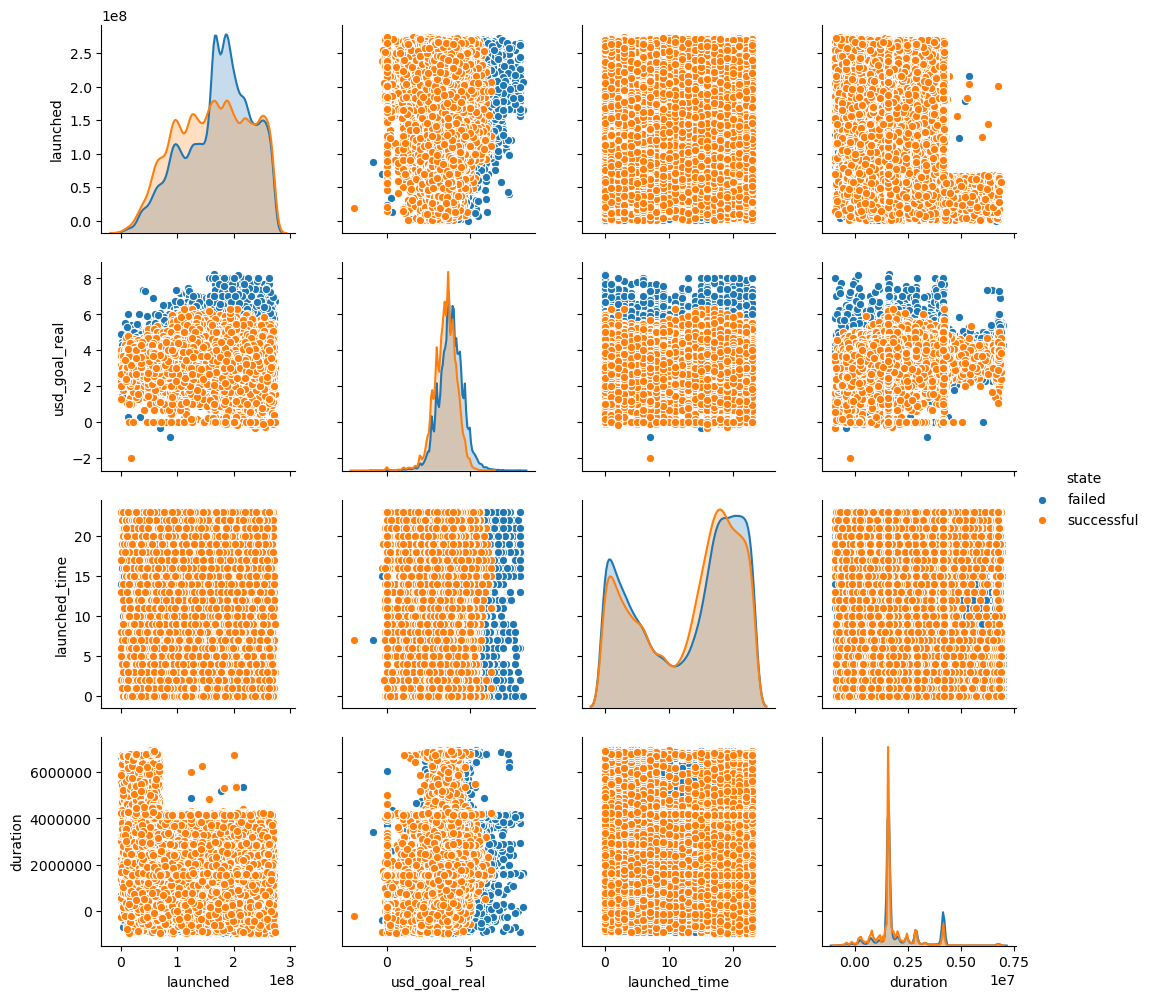

In [271]:
sns.pairplot(df, hue='state')

In [279]:
df_std = copy.copy(df)

df_qnt = df_std[quantitative]
df_qnt_scaled = pd.DataFrame(stdsc.fit_transform(df_qnt.values), columns=quantitative, index=df_std.index)
df_std[quantitative] = df_qnt_scaled[quantitative]

### 特徴選択
- フィルター法：上のセルでやった
- ラッパー法：大変なのでやらない
- 埋め込み法：L1正則化を試してみる

In [299]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=.005) # 最後のグラフの見た目に合うように勝手に変えてみた

X, y = ready_to_fit(df_std)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

sfm.fit(X_train, y_train)

c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Depreca

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=0.005)

In [282]:
dir(sfm)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_get_param_names',
 '_get_support_mask',
 'estimator',
 'estimator_',
 'fit',
 'fit_transform',
 'get_params',
 'get_support',
 'inverse_transform',
 'max_features',
 'norm_order',
 'partial_fit',
 'prefit',
 'set_params',
 'threshold',
 'threshold_',
 'transform']

In [295]:
sfm.get_support()

array([ True,  True, False,  True,  True, False,  True,  True,  True,
       False,  True, False,  True, False,  True,  True,  True, False,
       False,  True,  True,  True,  True, False,  True,  True, False,
        True, False,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True])

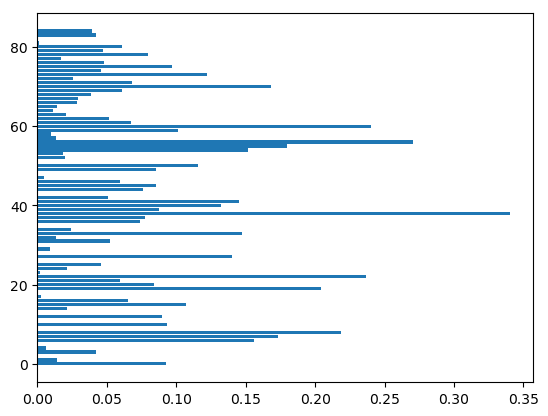

In [293]:
abs_coef = np.abs(sfm.estimator_.coef_)
plt.barh(np.arange(0, len(abs_coef)), abs_coef)#, tick_label=df_std.columns.values)
plt.show()

In [303]:
# log-regression with L1-embedded data
X_train_embedded = X_train[:, sfm.get_support()]
X_test_embedded = X_test[:, sfm.get_support()]

clf = SGDClassifier(loss='log',
                    # penalty='l2',
                    # l1_ratio=0.15, # for ElasticNet
                    fit_intercept=True,
                    random_state=1234,
                    max_iter=1e5,
                    tol=1e-3)

clf.fit(X_train_embedded, y_train) # too heavy calculation

y_est = clf.predict(X_test_embedded)
show_scores(y_test, y_est)

acurracy: 0.669, precision: 0.612, recall: 0.484
MSE: 0.331, MAE: 53.057


c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\linear_model\base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


### Decision Tree

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

In [306]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)
clf = clf.fit(X_train_embedded, y_train)

# print("score=", clf.score(X_train_embedded, y_train))
# print(clf.predict(X_test_embedded)) #予測したい場合

y_est = clf.predict(X_test_embedded)

c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)


array([1, 0, 1, ..., 0, 0, 0], dtype=uint8)

In [313]:
show_scores(y_test, y_est)
clf.score(X_test_embedded, y_test), clf.score(X_train_embedded, y_train)

# It seems to be overfit to train data

acurracy: 0.616, precision: 0.523, recall: 0.504
MSE: 0.384, MAE: 51.073


(0.6156026230496722, 0.8915538235992447)

In [326]:
# GridSearchCV: find the best hyperparmeter combination.
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [5, 10, 15, 20], 
    'min_samples_split': [10, 100, 1000], 
    'min_samples_leaf': [10, 100, 100]
}

model = clf = DecisionTreeClassifier(criterion="gini", random_state=1234)

clf = GridSearchCV(model, parameters, cv=5)
# clf.fit(X_train_embedded, y_train)
# Takes 7.5 min

c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\model_selection\_split.py:665: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. I

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 15, 20], 'min_samples_split': [10, 100, 1000], 'min_samples_leaf': [10, 100, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [329]:
print(f'params: {clf.best_params_}')

y_est = clf.predict(X_test_embedded)
show_scores(y_test, y_est)

params: {'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 1000}
acurracy: 0.679, precision: 0.623, recall: 0.511
MSE: 0.321, MAE: 50.313


In [343]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                             max_depth=20, min_samples_split=1000, min_samples_leaf=10,
                             random_state=1234)


clf.fit(X_train_embedded, y_train)

c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\ensemble\forest.py:487: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=1000,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [344]:
# print(f'feature importances = {clf.feature_importances_}')

y_est = clf.predict(X_test_embedded)
show_scores(y_test, y_est)

# Recall seems to be low, while precision was increased.

c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


acurracy: 0.681, precision: 0.657, recall: 0.437
MSE: 0.319, MAE: 57.888


In [342]:
# Adaboost modeling
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf = AdaBoostClassifier(
    DecisionTreeClassifier(
        max_depth=20,
        min_samples_leaf=10,
        min_samples_split=1000, 
        random_state=1234,
        criterion="gini"),
    
    n_estimators=100, 
    random_state=1234)

clf.fit(X_train_embedded, y_train)


c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cur

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=1000,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=1234)

In [341]:
# Adaboost validation
show_scores(y_test, clf.predict(X_test_embedded))

acurracy: 0.680, precision: 0.616, recall: 0.548
MSE: 0.320, MAE: 46.513


### Neural network

In [345]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import display
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras  
import tensorflow as tf

c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\tensorflow\python\frame

In [351]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(57, activation='relu', input_dim=X_train_embedded.shape[1]))
model.add(Dense(67, activation='relu', input_dim=57))
model.add(Dense(50, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# WARNINGが出るが気にしなくて良い

In [352]:
# 計算の実行
fit = model.fit(X_train_embedded, y_train,
          epochs=20,
          batch_size=20,validation_data=(X_test_embedded, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.show()

# df[["acc", "val_acc"]].plot()
# plt.ylabel("acc")
# plt.xlabel("epoch")
# plt.ylim([0,1.0])
# plt.show()

Train on 265339 samples, validate on 66335 samples
Epoch 1/50
265339/265339 [==============================] - 16s 62us/sample - loss: 0.6085 - acc: 0.6663 - val_loss: 0.5952 - val_acc: 0.6736
Epoch 2/50
265339/265339 [==============================] - 16s 59us/sample - loss: 0.5929 - acc: 0.6763 - val_loss: 0.5874 - val_acc: 0.6797
Epoch 3/50
265339/265339 [==============================] - 16s 61us/sample - loss: 0.5894 - acc: 0.6786 - val_loss: 0.6015 - val_acc: 0.6689
Epoch 4/50
265339/265339 [==============================] - 16s 60us/sample - loss: 0.5869 - acc: 0.6808 - val_loss: 0.5840 - val_acc: 0.6845
Epoch 5/50
265339/265339 [==============================] - 17s 64us/sample - loss: 0.5851 - acc: 0.6833 - val_loss: 0.5812 - val_acc: 0.6880
Epoch 6/50
265339/265339 [==============================] - 16s 60us/sample - loss: 0.5838 - acc: 0.6839 - val_loss: 0.5858 - val_acc: 0.6815
Epoch 7/50
265339/265339 [==============================] - 16s 59us/sample - loss: 0.5825 - acc:

KeyboardInterrupt: 